In [78]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt 
%matplotlib inline

import math
from scipy import stats

from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore') 

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score

from sklearn.metrics import confusion_matrix


In [79]:
asos_df = pd.read_csv('asos_reviews_clean_date.csv')

In [80]:
plt_df = pd.read_csv('plt_reviews_clean_date.csv')

In [81]:
zahul_df = pd.read_csv('zaful_reviews_clean_date.csv')

In [82]:
reviews_df = pd.concat([asos_df, plt_df, zahul_df], axis = 0)

In [83]:
reviews_df

,Unnamed: 0,date,review,stars,length,polarity_before_clean,lower,no_punc,no_stop,no_num,words_removed,token,pos_tags,lemmatized,joined,polarity_after_clean
0,0,2020-12-09,Cristy was amazing ...,5,225,0.580208,cristy was amazing i spoke with cristy and she...,cristy was amazing i spoke with cristy and she...,cristy amazing spoke cristy brilliant although...,cristy amazing spoke cristy brilliant although...,cristy amazing spoke cristy brilliant although...,"['cristy', 'amazing', 'spoke', 'cristy', 'bril...","[('cristy', 'JJ'), ('amazing', 'VBG'), ('spoke...","['cristy', 'amaze', 'spoke', 'cristy', 'brilli...",cristy amaze spoke cristy brilliant although c...,0.536111
1,1,2020-12-09,Unhappy customer ...,1,1694,-0.061012,unhappy customer i placed an order at the end ...,unhappy customer i placed an order at the end ...,unhappy customer placed order end november bla...,unhappy customer placed order end november bla...,unhappy placed end november black friday disco...,"['unhappy', 'placed', 'end', 'november', 'blac...","[('unhappy', 'JJ'), ('placed', 'VBD'), ('end',...","['unhappy', 'place', 'end', 'november', 'black...",unhappy place end november black friday discou...,-0.201667
2,2,2020-12-09,Still Waiting P...,2,145,-0.195000,still waiting placed an order 3rd december and...,still waiting placed an order 3rd december and...,still waiting placed order 3rd december still ...,still waiting placed order rd december still w...,still waiting placed rd december still waiting...,"['still', 'waiting', 'placed', 'rd', 'december...","[('still', 'RB'), ('waiting', 'VBG'), ('placed...","['still', 'wait', 'place', 'rd', 'december', '...",still wait place rd december still wait suppos...,-0.300000
3,3,2020-12-09,Great after sales support ...,5,94,0.900000,great after sales support great after sales su...,great after sales support great after sales su...,great sales support great sales support thank,great sales support great sales support thank,great sales support great sales support thank,"['great', 'sales', 'support', 'great', 'sales'...","[('great', 'JJ'), ('sales', 'NNS'), ('support'...","['great', 'sale', 'support', 'great', 'sale', ...",great sale support great sale support thank,0.800000
4,4,2020-12-09,Michael was very polite and helpful… ...,5,139,0.200000,michael was very polite and helpful… michael w...,michael was very polite and helpful michael wa...,michael polite helpful michael polite helpful ...,michael polite helpful michael polite helpful ...,michael polite helpful michael polite helpful ...,"['michael', 'polite', 'helpful', 'michael', 'p...","[('michael', 'NN'), ('polite', 'VBP'), ('helpf...","['michael', 'polite', 'helpful', 'michael', 'p...",michael polite helpful michael polite helpful ...,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8594,8594,2015-06-01,Terrible Company ...,1,416,-0.175000,terrible company it has been 18 days since the...,terrible company it has been 18 days since the...,terrible company 18 days since order placed pa...,terrible company days since order placed paid...,terrible company days since placed paid compla...,"['terrible', 'company', 'days', 'since', 'plac...","[('terrible', 'JJ'), ('company', 'NN'), ('days...","['terrible', 'company', 'day', 'since', 'place...",terrible company day since place paid complain...,-0.500000
8595,8595,2015-05-22,Horrible The cl...,1,418,-0.125000,horrible the clothes may look adorable but you...,horrible the clothes may look adorable but you...,horrible clothes may look adorable never get p...,horrible clothes may look adorable never get p...,horrible clothes may look adorable never get p...,"['horrible', 'clothes', 'may', 'look', 'adorab...","[('horrible', 'JJ'), ('clothes', 'NNS'), ('may...","['horrible', 'clothes', 'may', 'look', 'adorab...",horrible clothes may look adorable never get p...,-0.125000
8596,8596,2015-05-14,Where is my order? ...,2,323,0.537500,where is my order? 20 days and counting. never...,where is my order 20 days a

In [84]:
reviews_df = reviews_df.drop(['Unnamed: 0'], axis = 1)

In [85]:
reviews_df.shape

(48556, 15)

In [86]:
reviews_df['review'].value_counts().head(10)

Very helpful                  102
Great service                  33
very helpful                   28
Great customer service         26
Very helpful!                  17
Excellent customer service     15
Great customer service!        15
Really helpful                 12
Good service                   12
Excellent service              11
Name: review, dtype: int64

In [87]:
# I remove the duplicate reviews since the dataset is large enough

reviews_df = reviews_df.drop_duplicates(subset = 'review', keep = 'first')

In [88]:
reviews_df['stars'].value_counts()

5    33929
1     8161
4     3850
2     1101
3      932
Name: stars, dtype: int64

In [89]:
analysis_df = reviews_df[['stars', 'lemmatized', 'date', 'length', 'polarity_after_clean']]

In [90]:
analysis_df['stars']

0       5
1       1
2       2
3       5
4       5
       ..
8594    1
8595    1
8596    2
8597    1
8598    1
Name: stars, Length: 47973, dtype: int64

In [91]:
analysis_df['stars'].value_counts()

5    33929
1     8161
4     3850
2     1101
3      932
Name: stars, dtype: int64

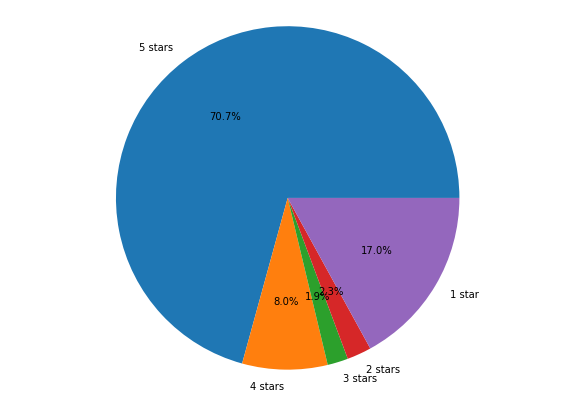

In [92]:
plt.figure(figsize =(10, 7)) 
plt.pie([33929, 3850, 932, 1101, 8161], labels = ['5 stars', '4 stars', '3 stars', '2 stars', '1 star'], autopct='%1.1f%%');
plt.axis('equal')
plt.show()

In [93]:
# Create smaller random samples from each rating to crate a balanced sample

sample_5 = analysis_df[analysis_df['stars']==5].sample(1000)
sample_4 = analysis_df[analysis_df['stars']==4].sample(1000)
sample_3 = analysis_df[analysis_df['stars']==3]
sample_2 = analysis_df[analysis_df['stars']==2].sample(1000)
sample_1 = analysis_df[analysis_df['stars']==1].sample(1000)


In [94]:
# Checking so that the samples are representative

In [95]:
analysis_df[analysis_df['stars']==5]['polarity_after_clean'].describe()

count    33929.000000
mean         0.371516
std          0.251206
min         -1.000000
25%          0.200000
50%          0.354167
75%          0.526667
max          1.000000
Name: polarity_after_clean, dtype: float64

In [96]:
sample_5['polarity_after_clean'].describe()

count    1000.000000
mean        0.385802
std         0.250451
min        -0.500000
25%         0.203579
50%         0.367708
75%         0.543750
max         1.000000
Name: polarity_after_clean, dtype: float64

We calculate the Z-statistic to check that the random samples are representative of the larger sample

H0: The random sample mean is the same as the mean of the full sample

HA: The means are not the same

If -1.98 < Z < 1.98 we do not reject the null hypothesis at 95% level of confidence and we can assume that the smaller samples are representative of the full sample.


In [97]:
n_5 = 1000
pop_mean_5 = 0.371516
sample_mean_5 = 0.374292
pop_std_5 = 0.251206

statistic_5 = (sample_mean_5 - pop_mean_5) / (pop_std_5 / math.sqrt(n_5))
print('The Z statistic is: ', statistic_5)

The Z statistic is:  0.34945354747209156


In [98]:
analysis_df[analysis_df['stars']==4]['polarity_after_clean'].describe()

count    3850.000000
mean        0.298890
std         0.226388
min        -1.000000
25%         0.160000
50%         0.300000
75%         0.438889
max         1.000000
Name: polarity_after_clean, dtype: float64

In [99]:
sample_4['polarity_after_clean'].describe()

count    1000.000000
mean        0.292823
std         0.221615
min        -0.700000
25%         0.162227
50%         0.289643
75%         0.430729
max         1.000000
Name: polarity_after_clean, dtype: float64

In [100]:
n_4 = 1000
pop_mean_4 = 0.298890
sample_mean_4 = 0.306799
pop_std_4 = 0.226388

statistic_4 = (sample_mean_4 - pop_mean_4) / (pop_std_4 / math.sqrt(n_4))
print('The Z statistic is: ', statistic_4)

The Z statistic is:  1.1047605886474419


In [101]:
analysis_df[analysis_df['stars']==2]['polarity_after_clean'].describe()

count    1101.000000
mean        0.013041
std         0.222674
min        -1.000000
25%        -0.090476
50%         0.000000
75%         0.125000
max         1.000000
Name: polarity_after_clean, dtype: float64

In [102]:
sample_2['polarity_after_clean'].describe()

count    1000.000000
mean        0.013801
std         0.225122
min        -1.000000
25%        -0.087595
50%         0.000000
75%         0.125417
max         1.000000
Name: polarity_after_clean, dtype: float64

In [103]:
n_2 = 1000
pop_mean_2 = 0.013041
sample_mean_2 = 0.017669
pop_std_2 = 0.222674

statistic_2 = (sample_mean_2 - pop_mean_2) / (pop_std_2 / math.sqrt(n_2))
print('The Z statistic is: ', statistic_2)

The Z statistic is:  0.6572397770399444


In [104]:
analysis_df[analysis_df['stars']==1]['polarity_after_clean'].describe()

count    8161.000000
mean       -0.107879
std         0.271774
min        -1.000000
25%        -0.233523
50%        -0.054630
75%         0.043290
max         1.000000
Name: polarity_after_clean, dtype: float64

In [105]:
sample_1['polarity_after_clean'].describe()

count    1000.000000
mean       -0.114450
std         0.266864
min        -1.000000
25%        -0.233730
50%        -0.071429
75%         0.028792
max         0.900000
Name: polarity_after_clean, dtype: float64

In [106]:
n_1 = 1000
pop_mean_1 = -0.107879
sample_mean_1 = -0.113292
pop_std_1 = 0.271774

statistic_1 = (sample_mean_1 - pop_mean_1) / (pop_std_1 / math.sqrt(n_1))
print('The Z statistic is: ', statistic_1)

The Z statistic is:  -0.6298398292144002


In [107]:
new_df = pd.concat([sample_5, sample_4, sample_3, sample_2, sample_1])

In [108]:
X = new_df['lemmatized']
y = new_df['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [109]:
X_train

1899     ['disappoint', 'impressed', 'packaging', 'clot...
12810    ['partner', 'bad', 'delivery', 'servicehermes'...
14430    ['jean', 'size', 'big', 'fast', 'delivery', 'j...
7335     ['shop', 'elsewhere', 'two', 'sweater', 'site'...
9740     ['never', 'receive', 'edit', 'reach', 'refunde...
                               ...                        
3151     ['item', 'deliver', 'item', 'deliver', 'multip...
7035     ['wasted', 'time', 'im', 'australia', 'first',...
4504     ['enjoy', 'really', 'enjoyed', 'experience', '...
19013    ['quality', 'item', 'poor', 'quality', 'item',...
2404     ['suite', 'suite', 'take', 'week', 'arrive', '...
Name: lemmatized, Length: 3945, dtype: object

In [110]:
X_test

6053     ['good', 'qulaity', 'overall', 'pleased', 'pro...
3334     ['coupon', 'issue', 'use', 'coupon', 'new', 'p...
2314     ['return', 'enquiry', 'covid', 'place', 'april...
1848     ['love', 'order', 'love', 'order', 'ive', 'com...
3956     ['make', 'day', 'ago', 'though', 'make', 'day'...
                               ...                        
2871     ['problem', 'company', 'problem', 'company', '...
17186    ['fb', 'messenger', 'fb', 'messenger', 'brilli...
5709     ['good', 'respond', 'good', 'respond', 'size',...
1139     ['functional', 'thats', 'functional', 'thats',...
5489     ['hit', 'miss', 'hit', 'miss', 'thought', 'exp...
Name: lemmatized, Length: 987, dtype: object

In [111]:
y_train

1899     2
12810    1
14430    2
7335     2
9740     2
        ..
3151     1
7035     2
4504     4
19013    3
2404     3
Name: stars, Length: 3945, dtype: int64

In [112]:
y_test

6053     4
3334     3
2314     3
1848     3
3956     2
        ..
2871     2
17186    4
5709     3
1139     2
5489     3
Name: stars, Length: 987, dtype: int64

Modelling using balanced sample.

I create a model pipeline including the vectorizer, TfidfTransformer and classifier

# Naive Bayes (Multinomial)

In [113]:
model_nb = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),                    # ignore terms that have a document frequency lower than 5
                   ('tfidf', TfidfTransformer()),                                                   # include unigrams and bigrams
                   ('clf', MultinomialNB()),
                   ])

model_nb.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_nb.predict(X_test)

In [114]:
print('The model accuracy is %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

The model accuracy is 0.513677811550152
              precision    recall  f1-score   support

           1       0.56      0.74      0.64       201
           2       0.41      0.43      0.42       202
           3       0.48      0.25      0.33       181
           4       0.45      0.46      0.46       196
           5       0.62      0.66      0.64       207

    accuracy                           0.51       987
   macro avg       0.51      0.51      0.50       987
weighted avg       0.51      0.51      0.50       987



In [115]:
print(confusion_matrix(ytest, pred_y))

[[149  49   1   1   1]
 [ 71  86  28  11   6]
 [ 30  55  45  36  15]
 [ 10  16  17  90  63]
 [  5   3   2  60 137]]


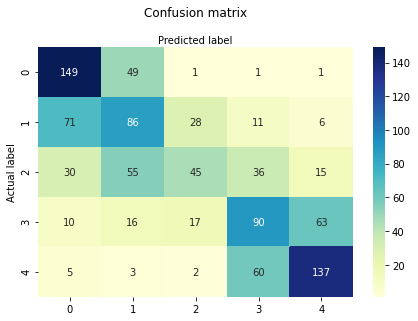

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np

cnf_matrix = metrics.confusion_matrix(ytest, pred_y)
cnf_matrix
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu" ,fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

We will compare the results from the Multinomial Naive Bayes model with some other common models

# Logistic Regression

In [117]:
model_lr = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegression(class_weight='balanced')),
                   ])

model_lr.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_lr.predict(X_test)

In [118]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.5298885511651469
              precision    recall  f1-score   support

           1       0.67      0.69      0.68       201
           2       0.44      0.45      0.44       202
           3       0.42      0.38      0.40       181
           4       0.45      0.41      0.43       196
           5       0.64      0.69      0.66       207

    accuracy                           0.53       987
   macro avg       0.52      0.53      0.52       987
weighted avg       0.52      0.53      0.53       987



In [119]:
print(confusion_matrix(ytest, pred_y))

[[139  49   9   2   2]
 [ 47  91  49   9   6]
 [ 16  47  69  36  13]
 [  5  16  33  81  61]
 [  2   5   4  53 143]]


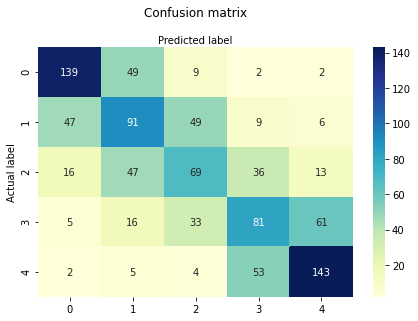

In [120]:
cnf_matrix = metrics.confusion_matrix(ytest, pred_y)
cnf_matrix
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu" ,fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

# Decision Tree

In [121]:
model_dt = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', DecisionTreeClassifier(class_weight='balanced')),
                   ])

model_dt.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_dt.predict(X_test)

In [122]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.3677811550151976
              precision    recall  f1-score   support

           1       0.44      0.44      0.44       201
           2       0.28      0.28      0.28       202
           3       0.27      0.25      0.26       181
           4       0.29      0.29      0.29       196
           5       0.53      0.56      0.54       207

    accuracy                           0.37       987
   macro avg       0.36      0.36      0.36       987
weighted avg       0.37      0.37      0.37       987



In [123]:
print(confusion_matrix(ytest, pred_y))

[[ 89  65  27  15   5]
 [ 59  57  42  32  12]
 [ 24  46  45  42  24]
 [ 21  22  36  57  60]
 [  8  15  17  52 115]]


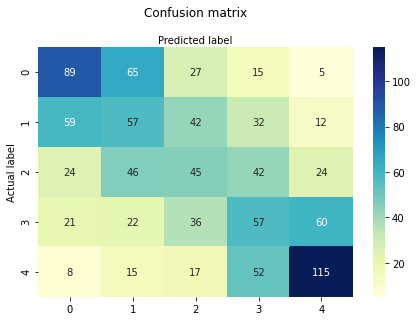

In [124]:
cnf_matrix = metrics.confusion_matrix(ytest, pred_y)
cnf_matrix
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu" ,fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

# Random Forest

In [125]:
model_rf = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', RandomForestClassifier(class_weight='balanced')),
                   ])

model_rf.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_rf.predict(X_test)

In [126]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.48834853090172237
              precision    recall  f1-score   support

           1       0.53      0.73      0.62       201
           2       0.42      0.40      0.41       202
           3       0.46      0.23      0.31       181
           4       0.41      0.32      0.36       196
           5       0.54      0.73      0.62       207

    accuracy                           0.49       987
   macro avg       0.47      0.48      0.46       987
weighted avg       0.47      0.49      0.47       987



In [127]:
print(confusion_matrix(ytest, pred_y))

[[146  42   4   3   6]
 [ 74  80  21  13  14]
 [ 38  39  42  36  26]
 [ 10  21  21  63  81]
 [  5   8   4  39 151]]


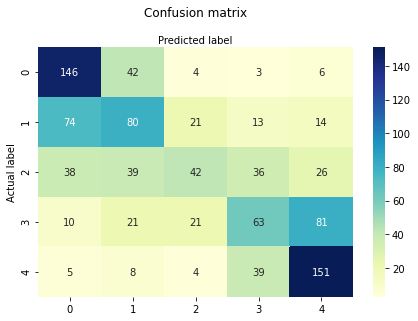

In [128]:
cnf_matrix = metrics.confusion_matrix(ytest, pred_y)
cnf_matrix
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu" ,fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

# Support Vector Machines (SVM)

In [129]:
model_svm = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', svm.SVC(class_weight='balanced')),
                   ])

model_svm.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_svm.predict(X_test)

In [130]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.5379939209726444
              precision    recall  f1-score   support

           1       0.68      0.64      0.66       201
           2       0.43      0.51      0.47       202
           3       0.45      0.40      0.42       181
           4       0.47      0.43      0.45       196
           5       0.65      0.69      0.67       207

    accuracy                           0.54       987
   macro avg       0.54      0.53      0.53       987
weighted avg       0.54      0.54      0.54       987



In [131]:
print(confusion_matrix(ytest, pred_y))

[[129  61   8   2   1]
 [ 44 104  42   7   5]
 [ 11  54  72  33  11]
 [  4  16  31  84  61]
 [  3   5   6  51 142]]


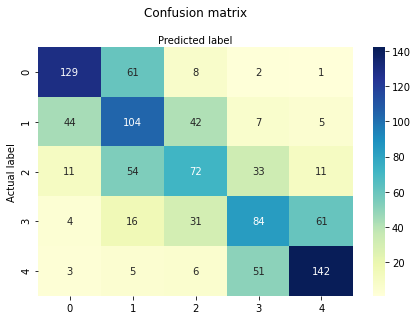

In [132]:
cnf_matrix = metrics.confusion_matrix(ytest, pred_y)
cnf_matrix
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu" ,fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

Modeling using the full sample - unbalanced.

In [133]:
analysis_df['stars'].value_counts()

5    33929
1     8161
4     3850
2     1101
3      932
Name: stars, dtype: int64

In [134]:
X = analysis_df['lemmatized']
y = analysis_df['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [135]:
X_train

2533    ['unexpectedly', 'great', 'first', 'saw', 'zaf...
8704    ['get', 'back', 'fast', 'solve', 'get', 'back'...
1877    ['hadnt', 'receive', 'part', 'package', 'hadnt...
8473    ['onshore', 'solve', 'offshore', 'dont', 'wast...
3293    ['make', 'put', 'wrong', 'email', 'make', 'put...
                              ...                        
1802    ['brilliant', 'brilliant', 'answer', 'question...
6517    ['love', 'blue', 'bikini', 'buy', 'light', 'bl...
3239    ['love', 'love', 'great', 'site', 'give', 'gre...
4193    ['probably', 'time', 'fromzaful', 'wow', 'prob...
2771                                 ['helpful', 'quick']
Name: lemmatized, Length: 38378, dtype: object

In [136]:
X_test

11759    ['adam', 'great', 'job', 'assist', 'adam', 'gr...
18243    ['speedy', 'delivery', 'speedy', 'delivery', '...
8326     ['clear', 'precise', 'clear', 'precise', 'exac...
4857     ['pleasantly', 'surprise', 'thrilled', 'purcha...
2744     ['foysol', 'help', 'today', 'foysol', 'help', ...
                               ...                        
13840    ['good', 'service', 'give', 'refund', 'parcel'...
9535     ['wanted', 'country', 'want', 'country', 'post...
16162    ['a', 'twitter', 'team', 'twitter', 'especiall...
11279    ['refuse', 'refund', 'buy', 'monthly', 'usuall...
17744             ['jae', 'great', 'extremely', 'helpful']
Name: lemmatized, Length: 9595, dtype: object

In [137]:
y_train

2533    5
8704    5
1877    5
8473    3
3293    5
       ..
1802    5
6517    4
3239    4
4193    5
2771    5
Name: stars, Length: 38378, dtype: int64

In [138]:
y_test

11759    4
18243    5
8326     5
4857     5
2744     5
        ..
13840    5
9535     4
16162    5
11279    2
17744    5
Name: stars, Length: 9595, dtype: int64

# Naive Bayes

In [139]:
model_nb = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB()),
                   ])

model_nb.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_nb.predict(X_test)

In [140]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

# The model is only able to classify reviews that are rated 1 or 5 (the oversampled classes)

accuracy 0.8649296508598229
              precision    recall  f1-score   support

           1       0.82      0.92      0.87      1651
           2       0.00      0.00      0.00       215
           3       0.00      0.00      0.00       167
           4       0.47      0.01      0.02       745
           5       0.88      0.99      0.93      6817

    accuracy                           0.86      9595
   macro avg       0.43      0.39      0.36      9595
weighted avg       0.80      0.86      0.81      9595



In [141]:
print(confusion_matrix(ytest, pred_y))

[[1524    0    0    0  127]
 [ 173    0    0    1   41]
 [  77    0    0    1   89]
 [  40    0    0    7  698]
 [  43    0    0    6 6768]]


# Logistic Regression

In [142]:
model_lr = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegression(class_weight = 'balanced')),     # The attributre class_weight='balanced' helps balance uneven sample classes
                   ])

model_lr.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_lr.predict(X_test)

In [143]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.7696717040125065
              precision    recall  f1-score   support

           1       0.85      0.85      0.85      1651
           2       0.17      0.23      0.19       215
           3       0.12      0.21      0.16       167
           4       0.24      0.47      0.31       745
           5       0.94      0.82      0.87      6817

    accuracy                           0.77      9595
   macro avg       0.46      0.51      0.48      9595
weighted avg       0.84      0.77      0.80      9595



In [144]:
print(confusion_matrix(ytest, pred_y))

[[1396  136   65   26   28]
 [ 113   49   35   13    5]
 [  33   33   35   50   16]
 [  12   27   47  348  311]
 [  79   49  102 1030 5557]]


# Decision Tree

In [145]:
model_dt = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', DecisionTreeClassifier(class_weight='balanced')),
                   ])

model_dt.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_dt.predict(X_test)

In [146]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.7211047420531527
              precision    recall  f1-score   support

           1       0.68      0.66      0.67      1651
           2       0.09      0.14      0.11       215
           3       0.05      0.07      0.06       167
           4       0.17      0.22      0.19       745
           5       0.87      0.83      0.85      6817

    accuracy                           0.72      9595
   macro avg       0.37      0.38      0.37      9595
weighted avg       0.75      0.72      0.74      9595



In [147]:
print(confusion_matrix(ytest, pred_y))

[[1089  165   70   84  243]
 [ 101   30   16   18   50]
 [  42   20   12   33   60]
 [  71   28   26  161  459]
 [ 289  104  125  672 5627]]


# Random Forest

In [148]:
model_rf = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', RandomForestClassifier(class_weight='balanced')),
                   ])

model_rf.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_rf.predict(X_test)

In [149]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.8448150078165712
              precision    recall  f1-score   support

           1       0.83      0.82      0.82      1651
           2       0.00      0.00      0.00       215
           3       0.00      0.00      0.00       167
           4       0.40      0.00      0.01       745
           5       0.85      0.99      0.91      6817

    accuracy                           0.84      9595
   macro avg       0.42      0.36      0.35      9595
weighted avg       0.78      0.84      0.79      9595



In [150]:
print(confusion_matrix(ytest, pred_y))

[[1346    4    0    0  301]
 [ 134    0    0    0   81]
 [  54    0    0    1  112]
 [  27    0    1    2  715]
 [  54    0    3    2 6758]]


# Support Vector Machines (SVM)

In [151]:
model_svm = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', svm.SVC(class_weight = 'balanced')),
                   ])

model_svm.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_svm.predict(X_test)

In [152]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.8428348097967692
              precision    recall  f1-score   support

           1       0.80      0.95      0.87      1651
           2       0.20      0.01      0.03       215
           3       0.11      0.01      0.02       167
           4       0.32      0.35      0.33       745
           5       0.92      0.92      0.92      6817

    accuracy                           0.84      9595
   macro avg       0.47      0.45      0.43      9595
weighted avg       0.82      0.84      0.83      9595



In [153]:
print(confusion_matrix(ytest, pred_y))

[[1574    5    3   14   55]
 [ 181    3    3   15   13]
 [  82    5    2   44   34]
 [  41    1    5  258  440]
 [  90    1    6  470 6250]]
